### Simple Chess AI Agent Utilizing the Minimax algorithm with Alpha Beta Pruning

TLDR

I implement a simple chess bot using the minimax search algorithm along with alpha beta pruning. The heuristic function used to evaluate each move in the search tree is based upon material count as well as piece positioning. The goal of this notebook is not to create the best chess engine out there, I simply wanted to get a feel for implementing these few algorithms and for designing a simple chess bot that could be played and makes somewhat sensible moves. Some improvements that could be made to this agent are connecting it to an openings databse as well as an endgames database. Computers are notorious for not understanding opening theories of chess as well as humans and therefore can benefit from theory that is already developed. Also, all endgames are solved, therefore if this agent had access to all endgames it would never lose.  The next exercise I plan to do with this is implement a simple agent that learns its own heuristic function through the use of reinforcement learning by playing against itself or other people thousands of times.

In [1]:
import chess
import numpy as np
import random

C:\Users\dylle\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\dylle\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\dylle\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.WCDJNK7YVMPZQ2ME2ZZHJJRJ3JIKNDB7.gfortran-win_amd64.dll
  stacklevel=1)


In [2]:
print(chess.__doc__)


A chess library with move generation and validation,
Polyglot opening book probing, PGN reading and writing,
Gaviota tablebase probing,
Syzygy tablebase probing, and XBoard/UCI engine communication.



Piece-Square Tables

These tables are used to give a score to each piece based upon which square it is on. The idea being that there are some squares that are more optimal for each type of piece and we want to reward the agent for moving the pieces to those squares when it makes sense.

https://www.chessprogramming.org/Simplified_Evaluation_Function

In [3]:
square_tables = {
    
    "P": np.array([ 0,  0,  0,  0,  0,  0,  0,  0,
50, 50, 50, 50, 50, 50, 50, 50,
10, 10, 20, 30, 30, 20, 10, 10,
 5,  5, 10, 25, 25, 10,  5,  5,
 0,  0,  0, 20, 20,  0,  0,  0,
 5, -5,-10,  0,  0,-10, -5,  5,
 5, 10, 10,-20,-20, 10, 10,  5,
 0,  0,  0,  0,  0,  0,  0,  0]).reshape(8,8),

"N": np.array([-50,-40,-30,-30,-30,-30,-40,-50,
-40,-20,  0,  0,  0,  0,-20,-40,
-30,  0, 10, 15, 15, 10,  0,-30,
-30,  5, 15, 20, 20, 15,  5,-30,
-30,  0, 15, 20, 20, 15,  0,-30,
-30,  5, 10, 15, 15, 10,  5,-30,
-40,-20,  0,  5,  5,  0,-20,-40,
-50,-40,-30,-30,-30,-30,-40,-50]).reshape(8,8),

"B": np.array([-20,-10,-10,-10,-10,-10,-10,-20,
-10,  0,  0,  0,  0,  0,  0,-10,
-10,  0,  5, 10, 10,  5,  0,-10,
-10,  5,  5, 10, 10,  5,  5,-10,
-10,  0, 10, 10, 10, 10,  0,-10,
-10, 10, 10, 10, 10, 10, 10,-10,
-10,  5,  0,  0,  0,  0,  5,-10,
-20,-10,-10,-10,-10,-10,-10,-20]).reshape(8,8),

"R": np.array([ 0,  0,  0,  0,  0,  0,  0,  0,
  5, 10, 10, 10, 10, 10, 10,  5,
 -5,  0,  0,  0,  0,  0,  0, -5,
 -5,  0,  0,  0,  0,  0,  0, -5,
 -5,  0,  0,  0,  0,  0,  0, -5,
 -5,  0,  0,  0,  0,  0,  0, -5,
 -5,  0,  0,  0,  0,  0,  0, -5,
  0,  0,  0,  5,  5,  0,  0,  0]).reshape(8,8),

"Q": np.array([-20,-10,-10, -5, -5,-10,-10,-20,
-10,  0,  0,  0,  0,  0,  0,-10,
-10,  0,  5,  5,  5,  5,  0,-10,
 -5,  0,  5,  5,  5,  5,  0, -5,
  0,  0,  5,  5,  5,  5,  0, -5,
-10,  5,  5,  5,  5,  5,  0,-10,
-10,  0,  5,  0,  0,  0,  0,-10,
-20,-10,-10, -5, -5,-10,-10,-20]).reshape(8,8),

"K": np.array([-30,-40,-40,-50,-50,-40,-40,-30,
-30,-40,-40,-50,-50,-40,-40,-30,
-30,-40,-40,-50,-50,-40,-40,-30,
-30,-40,-40,-50,-50,-40,-40,-30,
-20,-30,-30,-40,-40,-30,-30,-20,
-10,-20,-20,-20,-20,-20,-20,-10,
 20, 20,  0,  0,  0,  0, 20, 20,
 20, 30, 10,  0,  0, 10, 30, 20]).reshape(8,8)
}   


Here we are taking the mirror of the above tables to create the scores for the black pieces. Since the pieces play against each other while still having the same goals, we can simply flip the evaluation tables to get the proper scores for the black pieces.

In [5]:
square_tables["p"] = np.flip(square_tables["P"],0)
square_tables["n"] = np.flip(square_tables["N"],0)
square_tables["b"] = np.flip(square_tables["B"],0)
square_tables["r"] = np.flip(square_tables["R"],0)
square_tables["q"] = np.flip(square_tables["Q"],0)
square_tables["k"] = np.flip(square_tables["K"],0)

Here we create a a board object using the chess library

In [7]:
board = chess.Board()

Show casing the use of the legal_moves function and how it returns all legal moves of the current board state. We use this latter during with our minimax search algorithm to generate the tree of possible moves in each position for the agent to consider.

In [8]:
for move in board.legal_moves:
    print(move)

g1h3
g1f3
b1c3
b1a3
h2h3
g2g3
f2f3
e2e3
d2d3
c2c3
b2b3
a2a3
h2h4
g2g4
f2f4
e2e4
d2d4
c2c4
b2b4
a2a4


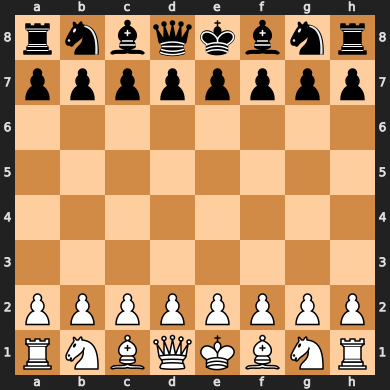

In [9]:
board

When we call a square using the chess API we are returned an integer between 0-63. However, when we want to index a matrix we use a coordinate system such as (0,1) for (row, col). Therefore, I wrote the function below to be used to convert the number returned by the API into a coordinate that can be used to index the board in matrix style.

In [10]:
def square_to_coordinate(square):
    """ take integer between 0-63 and returns its square coordinate
        in an 8x8 two dimensional matrix
    """
    return (square//8, square % 8)

In [20]:
square_to_coordinate(63)

(7, 7)

In [12]:
# heuristic function
def evaluate(board):
    
    
    """ 
       This function is used to return the score for the current board position,
       it makes an evaluation based upon material count for each side, as well as 
       how optimally each piece is placed in reference to each piece's sqaure eval table.
       Lastly, the function gives a score of 20,000 for any move resulting in a checkmate
       At the end of the function our score is calculated by adding up all the point for each side and then
       subtracting black's total from whites. This is done so that if the overal score for the position is negative
       we can infer that black is winning, and if the position's score is positive, then white is winning
    """
     
    w_material = 0
    b_material = 0
    
    w_square_values = 0
    b_square_values = 0
    
    piece_values = {
        chess.PAWN: 100,
        chess.ROOK: 500,
        chess.KNIGHT: 320,
        chess.BISHOP: 330,
        chess.QUEEN: 900,
        chess.KING: 20000
        
    }
    
    if board.outcome():
        # if move results in checkmate by white
        if board.is_checkmate and board.outcome().winner:
            w_material += 20000
            # if black makes checkmate 
        elif board.is_checkmate and not(board.outcome().winner):
            b_material += 20000
            
            
    for square in chess.SQUARES:
        piece = board.piece_at(square)
        
        if not piece:
            continue
        table = square_tables[str(piece)]
        square_value = table[square_to_coordinate(square)]
        
        if piece.color == chess.WHITE:
            w_material += piece_values[piece.piece_type]
            w_square_values += square_value
        else:
            b_material += piece_values[piece.piece_type]
            b_square_values += square_value
    

            
    w_total = w_material + w_square_values
    b_total = b_material + b_square_values
    
    score = w_total - b_total
            
    
    return score



In [13]:
def minimax_alphabeta(board, depth, maximizingPlayer, a=-np.Inf, b=np.Inf):
    """
    Minimax search algorithm that is utilizing alpha beta pruning to speed up search time
    """
    if depth == 0 or board.is_game_over():
        return evaluate(board)
    
    if maximizingPlayer:
        value = -np.Inf
        for move in board.legal_moves:
            board.push(move)
            value = max(value, minimax_alphabeta(board, depth - 1, False, a=a, b=b))
            board.pop()
            
            a = max(a, value)
            if b <= a:
                break
        return value
    
    else:
        value = np.Inf
        for move in board.legal_moves:
            board.push(move)
            value = min(value, minimax_alphabeta(board, depth - 1, True, a=a, b=b))
            board.pop()
            
            b = min(b, value)
            if b <= a:
                break
        
        return value

In [14]:
# Uses minimax to calculate value of making the move 
# function used to create a list of minimum moves that we can then take the maximum of since we are the maximizing player
# hence why we use False in the minimax function even though we are the maximizing player
def score_move_maximizingPlayer(move, nsteps):
    board.push(move)
    score = minimax_alphabeta(board, nsteps - 1, False)
    board.pop()
    return score

# basic idea is that we want to create a list that we can take the minimum of therefore this function should start
# as maximimizing player in regards to the minimax algorithm, thus returns list of maximum scores that we then take the minimum
# of because we are the minimizing player
def score_move_minimizingPlayer(move, nsteps):
    board.push(move)
    score = minimax_alphabeta(board, nsteps - 1, True)
    board.pop()
    return score

The larger we set the number of steps to be, the more computational power is required to run this agent. There are more search narrowing techniques that could be implemented to prune the search tree such as killer heuristics, move ordering, and several others. I plan to implement some of these improvements in the future. As for right now, the whole point of this exercise was to simply get a simple AI agent up and running utilizing the minimax search algorithm in conjunction with alpha beta pruning. The next exercise I plan to do with this is implement a simple agent that learns its own heuristic function through the use of reinforcement learning and playing against itself or other people thousands of times.

In [15]:
N_STEPS = 2

def my_agent(board, pieces):
    
    """
    AI agent that calculates the best move for each position at a predetermined depth based upon which
    color pieces it is told to play
    """
    # Get list of valid moves
    valid_moves = [move for move in board.legal_moves]

    
    if pieces == "white_pieces":
        # Use the heuristic to assign a score to each possible board in the next step
        scores = dict(zip(valid_moves, [score_move_maximizingPlayer(move, N_STEPS) for move in valid_moves]))
    
        moves = [key for key in scores.keys() if scores[key] == max(scores.values())]
        
    else:
        
        scores = dict(zip(valid_moves, [score_move_minimizingPlayer(move, N_STEPS) for move in valid_moves]))
        # Get a list of (moves) that minimize the heuristic since black pieces
        moves = [key for key in scores.keys() if scores[key] == min(scores.values())]
    
    
    # Select at random from the maximizing columns
    return random.choice(moves)

In [16]:
def human_move():
    """ 
     Takes an input and attempts to make the move
     if the move is invalid will prompt the user to try again
    """
    move = input()
    try:
        board.push_san(str(move))
    except:
        print("Must input valid move")
        human_move()
        

Checking to make sure the agent is behaving properly when playing with the black pieces

In [17]:
# checking to make sure the agent when playing with the black pieces is making the best move by
# making a checkmate in one situation occur
# this verifies that my logic for minimizing and maximizing the moves in my agent function is correct
playing = True
board = chess.Board('rnbqkbnr/pppp1ppp/8/4p3/8/5P2/PPPPP1PP/RNBQKBNR w KQkq - 0 2')
while playing:
    

    
    human_move()

    print(board)
    print(" ")
    print(" ")
    
    if board.is_game_over():
        print(board.outcome())
        break
        
    agent_move = my_agent(board,"black_pieces")
    board.push_san(str(agent_move))
    print(board)
    print(" ")
    print(" ")
    
    if board.is_game_over():
        print(board.outcome())
        break
    
    

g4
r n b q k b n r
p p p p . p p p
. . . . . . . .
. . . . p . . .
. . . . . . P .
. . . . . P . .
P P P P P . . P
R N B Q K B N R
 
 
r n b . k b n r
p p p p . p p p
. . . . . . . .
. . . . p . . .
. . . . . . P q
. . . . . P . .
P P P P P . . P
R N B Q K B N R
 
 
Outcome(termination=<Termination.CHECKMATE: 1>, winner=False)


Checking to make sure the agent is behaving properly when playing with the white pieces

In [18]:
# testing to make sure that when the agent has the white pieces it is making the best move for white by putting it in a 
# checkmate in one position
# this checks to make sure that my coding logic for my agent function is correct
playing = True
board = chess.Board('r1bqkbnr/ppp2ppp/2np4/4p2Q/2B1P3/8/PPPP1PPP/RNB1K1NR w KQkq - 2 4')
while playing:
    
    
    agent_move = my_agent(board,"white_pieces")
    board.push_san(str(agent_move))
    print(board)
    print(" ")
    print(" ")
    
    if board.is_game_over():
        print(board.outcome())
        break
    
        human_move()
        print(board)
        print(" ")
        print(" ")
    
    if board.is_game_over():
        print(board.outcome())
        break

r . b q k b n r
p p p . . Q p p
. . n p . . . .
. . . . p . . .
. . B . P . . .
. . . . . . . .
P P P P . P P P
R N B . K . N R
 
 
Outcome(termination=<Termination.CHECKMATE: 1>, winner=True)


We can see that the agent is able to find the checkmate in 1 for both sets of pieces. 

Sources:
https://www.chessprogramming.org/Simplified_Evaluation_Function
https://python-chess.readthedocs.io/en/latest/core.html#outcome
https://www.kaggle.com/learn/intro-to-game-ai-and-reinforcement-learning
https://healeycodes.com/building-my-own-chess-engine
https://en.wikipedia.org/wiki/Alpha%E2%80%93beta_pruning